In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [54]:
N_classes = 4

class MotionDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_directory, window_size=100, is_train=True, transform=None):
        self.data_directory = data_directory
        self.window_size = window_size
        self.is_train = is_train
        self.dataset_x = []
        self.dataset_y = []
        self._initialize_dataset()

    def _initialize_dataset(self):
        raw_labels = open(self.data_directory + "/labels.txt", "r")
        self.dataset_x = []
        self.dataset_y = []
        current_exp, current_user = 0, 0
        acc_current_file_lines = []
        gyro_current_file_lines = []
        for line in raw_labels:
            # get the experiment and user data
            line_split = list(map(int,line.split()))

            # filter out the transition movements
            if line_split[2] > N_classes:
                continue

            # open new file if the current experiment and user are different from the previous run
            if line_split[0] != current_exp or line_split[1] != current_user:
                current_exp, current_user = line_split[0], line_split[1]

                # Get the accelerometer data
                current_file = open(self.data_directory + "/acc_exp" + str.zfill(str(current_exp), 2) + "_user" + str.zfill(str(current_user), 2) + ".txt", "r")
                # print("Opened file: " + current_file.name)
                # process lines
                acc_current_file_lines = []
                for file_line in current_file:
                    acc_current_file_lines.append(list(map(float, file_line.split())))
                current_file.close()

                # Get the gyro data
                current_file = open(self.data_directory + "/gyro_exp" + str.zfill(str(current_exp), 2) + "_user" + str.zfill(str(current_user), 2) + ".txt", "r")
                # print("Opened file: " + current_file.name)
                gyro_current_file_lines = []
                for file_line in current_file:
                    gyro_current_file_lines.append(list(map(float, file_line.split())))
                current_file.close()
            
            # get the label, start and end indices
            label, start, end = line_split[2:5]
            label -= 1 # convert to 0-indexed

            # sliding window
            for i in range(start, end - window_size, window_size):
                # calculate fft for the window
                acc_window = acc_current_file_lines[i:i+window_size]
                gyro_window = gyro_current_file_lines[i:i+window_size]
                inputs = np.concatenate((acc_window, gyro_window), axis=1)
                inputs = np.float32(np.transpose(inputs))
                self.dataset_x.append(inputs)
                self.dataset_y.append(label)

        raw_labels.close()

        print("Dataset initialized with size: " + str(len(self.dataset_y)))
        for i in range(N_classes):
            print("Class " + str(i) + " has " + str(self.dataset_y.count(i)) + " samples")

    def __len__(self):
        return len(self.dataset_y)

    def __getitem__(self, idx):
        return self.dataset_x[idx], self.dataset_y[idx]

window_size = 100   # 50Hz, 100 samples = 2s of movement
dataset = MotionDataset("HAPT Data Set/RawData", window_size)
classes = ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING')
print("shape of data: " + str(dataset[0][0].shape))

Dataset initialized with size: 4429
Class 0 has 1161 samples
Class 1 has 1078 samples
Class 2 has 979 samples
Class 3 has 1211 samples
shape of data: (6, 100)


In [55]:
# Sample data
dataset[0][0].shape

(6, 100)

In [56]:
# Setup training and testing data
batch_size = 32
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [57]:
device = torch.device("mps")
# device = torch.device("cpu")
print(device)

mps


# Setup the model

In [58]:
input_size = dataset[0][0].shape
print(input_size)

net = torch.nn.Sequential(
    torch.nn.Conv1d(6, 64, kernel_size=6, stride=1, padding=0),
    torch.nn.ReLU(),
    torch.nn.Conv1d(64, 64, kernel_size=6, stride=1, padding=0),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.LazyLinear(N_classes),
    torch.nn.Softmax()
)

net.to(device)

(6, 100)


/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential(
  (0): Conv1d(6, 64, kernel_size=(6,), stride=(1,))
  (1): ReLU()
  (2): Conv1d(64, 64, kernel_size=(6,), stride=(1,))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): LazyLinear(in_features=0, out_features=4, bias=True)
  (6): Softmax(dim=None)
)

In [59]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.SGD(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

In [60]:
min_valid_loss = np.inf
epochs = 100

In [61]:
net.train()
def get_num_correct(preds, labels):
    return preds.round().eq(labels).sum().item()

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    total_training_loss = 0.0
    batch_count = 0
    for i, data in enumerate(train_loader, 0):
        batch_count += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_training_loss += loss.item()
        vaccuracy = 0
            
    valid_loss = 0.0
    net.eval()     # Optional when not using Model Specific layer
    vcount = 0
    vcorrect = 0
    for j, vdata in enumerate(test_loader, 0):
        vcount += 1
        vdata, vlabels = vdata[0].to(device), vdata[1].to(device)
        # Forward Pass
        target = net(vdata)
        # Find the Loss
        loss = criterion(target,vlabels)
        # Calculate Loss
        valid_loss += loss.item()
        # Calculate accuracy
        vcorrect += (target.argmax(1) == vlabels).sum().item()
    valid_loss = valid_loss / vcount
    vaccuracy = vcorrect / len(test_loader.dataset)
    print(f'[Epoch:{epoch + 1:2d}] \t Training Loss: {running_loss / batch_count:5f} \t Validation Loss: {valid_loss:5f} \t Accuracy: {vaccuracy:5f}')
    
    # save model if loss improved, and obtain predictions
    if (valid_loss < min_valid_loss):
        min_valid_loss = valid_loss
        torch.save(net, "model.pt")
        print("evaluation loss reduced, model saved")
    scheduler.step(vaccuracy)

print('Finished Training')

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[Epoch: 1] 	 Training Loss: 0.980159 	 Validation Loss: 0.919870 	 Accuracy: 0.821670
evaluation loss reduced, model saved
[Epoch: 2] 	 Training Loss: 0.868010 	 Validation Loss: 0.840944 	 Accuracy: 0.910835
evaluation loss reduced, model saved
[Epoch: 3] 	 Training Loss: 0.817550 	 Validation Loss: 0.796667 	 Accuracy: 0.951467
evaluation loss reduced, model saved
[Epoch: 4] 	 Training Loss: 0.782856 	 Validation Loss: 0.783879 	 Accuracy: 0.966140
evaluation loss reduced, model saved
[Epoch: 5] 	 Training Loss: 0.771638 	 Validation Loss: 0.775548 	 Accuracy: 0.972912
evaluation loss reduced, model saved
[Epoch: 6] 	 Training Loss: 0.773124 	 Validation Loss: 0.774899 	 Accuracy: 0.969526
evaluation loss reduced, model saved
[Epoch: 7] 	 Training Loss: 0.765664 	 Validation Loss: 0.769959 	 Accuracy: 0.976298
evaluation loss reduced, model saved
[Epoch: 8] 	 Training Loss: 0.761204 	 Validation Loss: 0.764844 	 Accuracy: 0.983070
evaluation loss reduced, model saved
[Epoch: 9] 	 Tra

[Text(0.5, 14.09375, 'True'), Text(32.09374999999999, 0.5, 'Predicted')]

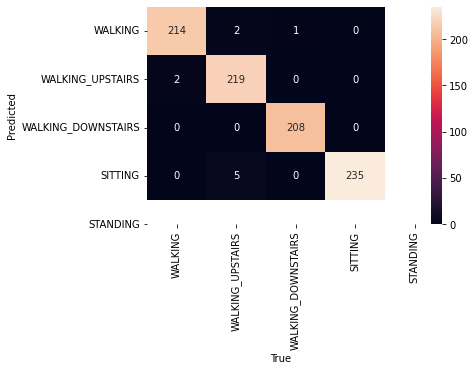

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

net = torch.load('model.pt')
net.eval()
y_pred = []
y_true = []
for j, vdata in enumerate(test_loader, 0):
    vdata, vlabels = vdata[0].to(device), vdata[1].to(device)
    output = net(vdata)
    y_pred.extend(output.argmax(1).cpu().numpy())
    y_true.extend(vlabels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
hm = sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
hm.set(xlabel="True", ylabel="Predicted")
